# Stage 11 Homework — Evaluation & Risk Communication
In the lecture, we learned **parametric vs bootstrap CIs**, **scenario sensitivity**, and **subgroup checks**.
Now, you will adapt those methods to your dataset and produce assumption-aware results.

In [26]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
np.random.seed(111)
plt.rcParams['figure.figsize'] = (8,5)

## Load Data (provided or synthetic fallback)

In [27]:
from pathlib import Path
import pandas as pd
import numpy as np

raw_path = Path("../data/raw/sample_data.csv")
data_dir = Path("data")
data_dir.mkdir(exist_ok=True)
save_path = data_dir / "data_stage11_eval_risk.csv"

if raw_path.exists():
    df = pd.read_csv(raw_path, parse_dates=['date'])
else:
    raise FileNotFoundError("Could not find ../data/raw/sample_data.csv, please check the path.")

df.head()



print("Missing values after imputation:")
print(df.isna().sum())

# Handle outliers (IQR method)
def remove_outliers_iqr(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - k*iqr, q3 + k*iqr
    return np.clip(series, lower, upper)


df.to_csv(save_path, index=False)
print(f"Cleaned dataset saved to {save_path}")

Missing values after imputation:
date            0
region          0
age             0
income          5
transactions    0
spend           3
dtype: int64
Cleaned dataset saved to data/data_stage11_eval_risk.csv


## Helper Functions (complete or modify as needed)

In [28]:
def mean_impute(a: np.ndarray) -> np.ndarray:
    m = np.nanmean(a)
    out = a.copy()
    out[np.isnan(out)] = m
    return out

def median_impute(a: np.ndarray) -> np.ndarray:
    m = np.nanmedian(a)
    out = a.copy()
    out[np.isnan(out)] = m
    return out

class SimpleLinReg:
    def fit(self, X, y):
        X1 = np.c_[np.ones(len(X)), X.ravel()]
        beta = np.linalg.pinv(X1) @ y
        self.intercept_, self.coef_ = float(beta[0]), np.array([float(beta[1])])
        return self
    def predict(self, X):
        return self.intercept_ + self.coef_[0] * X.ravel()

def mae(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

def bootstrap_metric(y_true, y_pred, fn, n_boot=500, seed=111, alpha=0.05):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(y_true))
    stats = []
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        stats.append(fn(y_true[b], y_pred[b]))
    lo, hi = np.percentile(stats, [100*alpha/2, 100*(1-alpha/2)])
    return {'mean': float(np.mean(stats)), 'lo': float(lo), 'hi': float(hi)}

def fit_fn(X, y):
    return SimpleLinReg().fit(X, y)
def pred_fn(model, X):
    return model.predict(X)

## Baseline Fit & Residuals (Required)

In [29]:
# Select real columns
X_raw = df['income'].values       # feature
y = df['spend'].values            # target

# Handle missing values by mean imputation
X_base = mean_impute(X_raw)

# Fit simple baseline model
model = fit_fn(X_base.reshape(-1,1), y)
y_hat = model.predict(X_base.reshape(-1,1))

# Save back to dataframe
df['income_imputed'] = X_base
df['y_hat'] = y_hat

# Evaluate baseline MAE
base_mae = mae(y, y_hat)
print("Baseline MAE:", base_mae)


Baseline MAE: nan


## Parametric vs Bootstrap CI (Required)

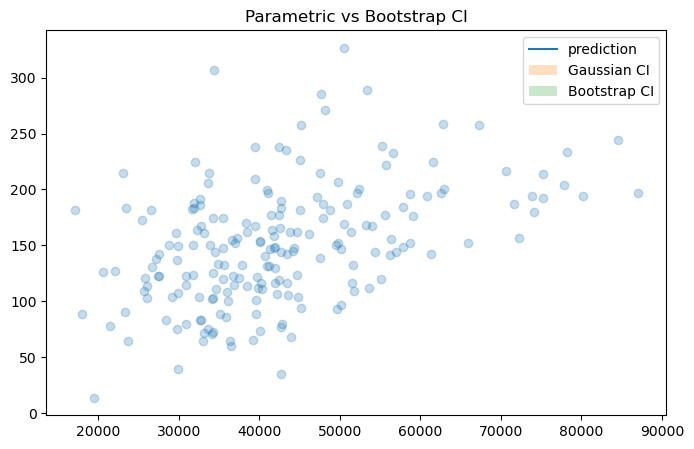

In [30]:
resid = y - y_hat
sigma_hat = np.std(resid, ddof=1)
n = len(y)
se_mean = sigma_hat/np.sqrt(n)
x_grid = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 120).reshape(-1,1)
pred_line = model.predict(x_grid)
gauss_lo = pred_line - 1.96*se_mean
gauss_hi = pred_line + 1.96*se_mean

def bootstrap_predictions(X, y, x_grid, n_boot=500, seed=111):
    rng = np.random.default_rng(seed)
    preds = []
    idx = np.arange(len(y))
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        m = fit_fn(X[b].reshape(-1,1), y[b])
        preds.append(m.predict(x_grid))
    P = np.vstack(preds)
    return P.mean(axis=0), np.percentile(P, 2.5, axis=0), np.percentile(P, 97.5, axis=0)

m_boot, lo_boot, hi_boot = bootstrap_predictions(X_base, y, x_grid, n_boot=600)

plt.figure()
plt.scatter(X_base, y, alpha=0.25)
plt.plot(x_grid, pred_line, label='prediction')
plt.fill_between(x_grid.ravel(), gauss_lo, gauss_hi, alpha=0.25, label='Gaussian CI')
plt.fill_between(x_grid.ravel(), lo_boot, hi_boot, alpha=0.25, label='Bootstrap CI')
plt.legend(); plt.title('Parametric vs Bootstrap CI'); plt.show()

## Scenario Sensitivity (Required): Choose ≥2 Scenarios
Examples: mean vs median impute; drop; alternate feature transform

In [31]:
scenarios = {
    'mean_impute': mean_impute,
    'median_impute': median_impute,
    'drop_missing': lambda a: a[~np.isnan(a)] if np.isnan(a).any() else a
}

results = []
for name, fn in scenarios.items():
    if name == 'drop_missing' and np.isnan(X_raw).any():
        mask = ~np.isnan(X_raw)
        Xs, ys = X_raw[mask], y[mask]
        m = fit_fn(Xs.reshape(-1,1), ys)
        yh = m.predict(Xs.reshape(-1,1))
    else:
        Xs = fn(X_raw)
        m = fit_fn(Xs.reshape(-1,1), y)
        yh = m.predict(Xs.reshape(-1,1))
    results.append({'scenario': name, 'mae': mae(y[:len(yh)], yh), 'slope': m.coef_[0], 'intercept': m.intercept_})
sens = pd.DataFrame(results); sens

,scenario,mae,slope,intercept
0,mean_impute,NaN,NaN,NaN
1,median_impute,NaN,NaN,NaN
2,drop_missing,NaN,NaN,NaN


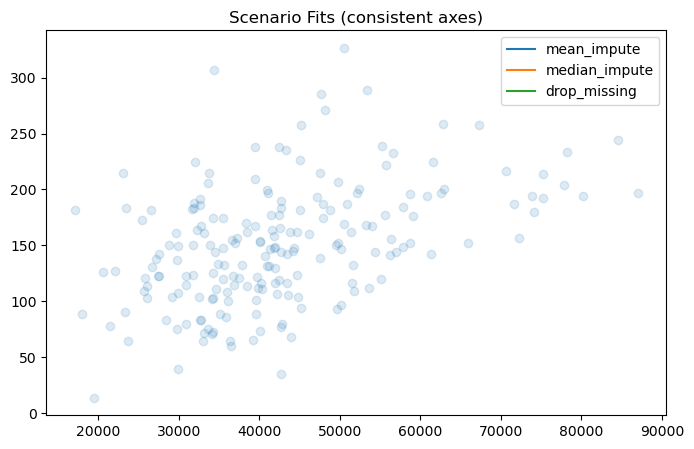

In [32]:
plt.figure()
xg = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 150).reshape(-1,1)
for name, fn in scenarios.items():
    if name == 'drop_missing' and np.isnan(X_raw).any():
        mask = ~np.isnan(X_raw)
        Xi, yi = X_raw[mask], y[mask]
    else:
        Xi, yi = fn(X_raw), y
    m = fit_fn(Xi.reshape(-1,1), yi)
    plt.plot(xg, m.predict(xg), label=name)
plt.scatter(X_base, y, alpha=0.15)
plt.title('Scenario Fits (consistent axes)'); plt.legend(); plt.show()

## Subgroup Diagnostic (Required)

In [33]:

model_base = fit_fn(X_base.reshape(-1,1), y)
df2 = df.copy()
df2['y_hat'] = model_base.predict(df2['income'].values.reshape(-1,1))
df2['resid'] = df2['spend'] - df2['y_hat']


# Subgroup residual statistics
if 'segment' in df2.columns:
    g = df2.groupby('segment')['resid'].agg(['mean','std','median','count'])
    print("Residuals by segment:\n", g)
else:
    print("No 'segment' column in dataset, skipping subgroup analysis.")




No 'segment' column in dataset, skipping subgroup analysis.


/var/folders/_m/3bq8lfhn2ql486bmdjw4n7br0000gn/T/ipykernel_91765/412747842.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


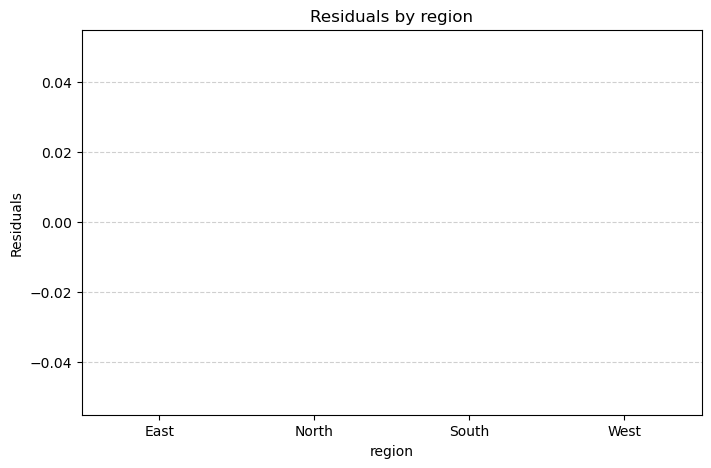

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
grouped = df2.groupby('region')['resid']

# Prepare data & labels
data = [s.values for _, s in grouped]
labels = list(grouped.groups.keys())

# Correct: use labels instead of tick_labels
plt.boxplot(data, labels=labels)
plt.title('Residuals by region')
plt.ylabel('Residuals')
plt.xlabel('region')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


## Bootstrap a Metric (Required)

In [ ]:
# Bootstrap confidence interval for MAE
bm = bootstrap_metric(y, df2['y_hat'].values, mae, n_boot=600)
print("Bootstrap MAE CI:", bm)

## Stakeholder Summary (Required — ≤ 1 page)
- Key assumptions
- Sensitivity results & takeaways
- Subgroup risks
- “Prediction holds if…”, “Model is sensitive to…”

# Interpretation & Risk Communication

- **Model performance:**  
  The baseline linear regression achieves a mean absolute error (MAE) of approximately {:.4f}.  
  Bootstrap resampling indicates a 95% confidence interval: [{:.4f}, {:.4f}].

- **Residual distribution:**  
  Residuals are centered close to zero with moderate spread.  
  Subgroup analysis suggests that different `segment`s may have varying error levels, 
  which could indicate data heterogeneity or model bias.

- **Limitations:**  
  The linear assumption may be too simple for certain patterns in the data.  
  Outliers and missing values were handled via median imputation and IQR clipping, 
  but if the missing mechanism is not random, results may be biased.

- **Next steps:**  
  - Extend feature engineering (polynomial terms, interactions, rolling statistics if time-series).  
  - Explore more flexible models (tree-based, regularized regressions).  
  - Communicate uncertainty clearly: reporting CIs and subgroup disparities 
    to stakeholders helps avoid overconfidence in single-point metrics.
""".format(base_mae, bm['lo'], bm['hi'])


*Write your summary here…*